Kickstarter
Dataset:
Kickstarter is a website that facilitates crowdfunding for products/ideas to come to fruition. This is an export of their data from 2014-2019

Intentions:
To predict the success of a kickstarter based on its attributes in comparison to similar kickstarters.

Future State:
There are over 160,000 records. We would like to narrow the set down to either a certain point in time, category, or country origin for more meaningful analysis. 
We will need to schedule a meeting with you before proceeding to the prediction code because it shows 100% of rows are outliers. Due to the outliers, our visualizations and interpretations are not being properly utilized.   

variable description:
id - Campaign id
name - Name of the Kickstarter Campaign.
currency - Currency used
main_category - Main category of the project.
sub_category - Sub_category of the project
launched_at - Launching date of the campaign
deadline - Deadline for the campaign. This is the date when the campaign ends.
duration - Number of days the campaign was online
goal_usd - Goal set by the campaign owner.
city - city
state - state
country - country
blurb_length - Word count of the description of campaign.
name_length - Word count of the name of campaign.
status - Status of the project
start_month - Month when the project started
end_month - Month when the project ended
start_Q - Quarter when the project started
end_Q - Quarter when the project ended
usd_pledged - Amount collected at the end of campaign in USD.

In [1]:
import pyspark
import pyspark.sql as sql
import pyspark.sql.functions as f
import pyspark.ml.feature as feat
import numpy as np

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1588783832882_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark.sql.functions import exp

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#import csv, making sure to account for quotes
df = spark.read.options(escape='"').csv("s3://projectbucket4567/Kickstarter.csv", header=True, inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#checking for duplicate rows
df.count(), df.distinct().count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(192548, 170730)

In [5]:
# remove the duplicated rows
removed_dup = df.dropDuplicates()
removed_dup.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

170730

In [6]:
# recount rows
no_ids = (
    removed_dup
    .select([col for col in removed_dup.columns if col != 'id'])
)
no_ids.count(), no_ids.distinct().count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(170730, 170730)

In [7]:
# show no duplicated rows
(
    removed_dup
    .groupby([col for col in removed_dup.columns if col != 'id'])
    .count()
    .filter('count > 1')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+-------------+------------+-----------+--------+--------+--------+----+-----+-------+------------+-----------+------+-----------+---------+-------+-----+-----------+-----+
|name|currency|main_category|sub_category|launched_at|deadline|duration|goal_usd|city|state|country|blurb_length|name_length|status|start_month|end_month|start_Q|end_Q|usd_pledged|count|
+----+--------+-------------+------------+-----------+--------+--------+--------+----+-----+-------+------------+-----------+------+-----------+---------+-------+-----+-----------+-----+
+----+--------+-------------+------------+-----------+--------+--------+--------+----+-----+-------+------------+-----------+------+-----------+---------+-------+-----+-----------+-----+

In [8]:
# remove the duplicated record
id_removed = removed_dup.dropDuplicates(
    subset = [col for col in removed_dup.columns if col != 'id']
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# finding duplicate IDs
import pyspark.sql.functions as fn
id_removed.agg(
      fn.count('id').alias('CountOfIDs')
    , fn.countDistinct('id').alias('CountOfDistinctIDs')
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+
|CountOfIDs|CountOfDistinctIDs|
+----------+------------------+
|    170730|            168467|
+----------+------------------+

In [10]:
# indentifying duplicate IDs

id_dup= (
    id_removed
    .groupby('id')
    .count()
    .filter('count > 1')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|        id|count|
+----------+-----+
|2068614138|    2|
| 811419352|    2|
| 989429327|    2|
|1049199152|    2|
| 863241522|    2|
|2026991333|    2|
|1684628655|    2|
| 754497367|    2|
|2031856669|    2|
|1709456941|    2|
|1393067601|    2|
|  24048809|    2|
| 719346197|    2|
| 543530159|    2|
|1739755633|    2|
| 917858560|    2|
| 779569124|    2|
|  37154313|    2|
| 340337733|    2|
|1819475028|    2|
+----------+-----+
only showing top 20 rows

In [11]:
# displaying a row with duplicate IDs
(
    id_removed
    .filter('id =63989445')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------------------+--------+-------------+------------+-------------------+-------------------+--------+------------------+-------+-----+-------+------------+-----------+----------+-----------+---------+-------+-----+------------+
|      id|               name|currency|main_category|sub_category|        launched_at|           deadline|duration|          goal_usd|   city|state|country|blurb_length|name_length|    status|start_month|end_month|start_Q|end_Q| usd_pledged|
+--------+-------------------+--------+-------------+------------+-------------------+-------------------+--------+------------------+-------+-----+-------+------------+-----------+----------+-----------+---------+-------+-----+------------+
|63989445|The Golden Railroad|     AUD|       comics| Comic Books|2017-11-20 15:47:13|2017-12-20 15:47:13|    30.0|        142.651216|Bendigo|  VIC|     AU|          23|          3|successful|         11|       12|     Q4|   Q4|207.28101096|
|63989445|The Golden Railroad|  

In [12]:
#dropping rows with duplicate IDs
x=df.dropDuplicates(['id'])
x.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

168467

In [13]:
#examine if there are any rows with missing values
x.rdd.map(
           lambda row: (
                 row['id']
               , sum([c == None for c in row])
           )
        )\
        .filter(lambda el: el[1] >= 1)\
        .count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [14]:
#drop row with missing values
merc_out = x.dropna(thresh=10)
x.count(), merc_out.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(168467, 168467)

In [15]:
#count percentage of missing values in each column
for k, v in sorted(
    merc_out.agg(*[
               (1 - (fn.count(c) / fn.count('*')))
                    .alias(c + '_miss')
               for c in merc_out.columns
           ])
        .collect()[0]
        .asDict()
        .items()
    , key=lambda el: el[1]
    , reverse=True
):
    print(k, v) #no columns had missing values

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

id_miss 0.0
name_miss 0.0
currency_miss 0.0
main_category_miss 0.0
sub_category_miss 0.0
launched_at_miss 0.0
deadline_miss 0.0
duration_miss 0.0
goal_usd_miss 0.0
city_miss 0.0
state_miss 0.0
country_miss 0.0
blurb_length_miss 0.0
name_length_miss 0.0
status_miss 0.0
start_month_miss 0.0
end_month_miss 0.0
start_Q_miss 0.0
end_Q_miss 0.0
usd_pledged_miss 0.0

In [16]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
#convert strings to int
merc_out = merc_out.withColumn("duration", merc_out["duration"].cast(IntegerType()))
merc_out = merc_out.withColumn("goal_usd", merc_out["goal_usd"].cast(IntegerType()))
merc_out = merc_out.withColumn("blurb_length", merc_out["blurb_length"].cast(IntegerType()))
merc_out = merc_out.withColumn("start_month", merc_out["start_month"].cast(IntegerType()))
merc_out = merc_out.withColumn("name_length", merc_out["name_length"].cast(IntegerType()))
data_df = merc_out.withColumn("usd_pledged", merc_out["usd_pledged"].cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
#checking data type. It says c7, c8, c19 are integers but then we recieved an error below saying they are still strings
data_df.schema

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

StructType(List(StructField(id,IntegerType,true),StructField(name,StringType,true),StructField(currency,StringType,true),StructField(main_category,StringType,true),StructField(sub_category,StringType,true),StructField(launched_at,TimestampType,true),StructField(deadline,TimestampType,true),StructField(duration,IntegerType,true),StructField(goal_usd,IntegerType,true),StructField(city,StringType,true),StructField(state,StringType,true),StructField(country,StringType,true),StructField(blurb_length,IntegerType,true),StructField(name_length,IntegerType,true),StructField(status,StringType,true),StructField(start_month,IntegerType,true),StructField(end_month,IntegerType,true),StructField(start_Q,StringType,true),StructField(end_Q,StringType,true),StructField(usd_pledged,IntegerType,true)))

In [19]:
df_pluscol = data_df.withColumn('percent_achieved', f.col('usd_pledged') / f.col('goal_usd') * 100)
df_pluscol.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+--------+-------------+--------------+-------------------+-------------------+--------+--------+---------+-------+-------+------------+-----------+----------+-----------+---------+-------+-----+-----------+------------------+
|      id|                name|currency|main_category|  sub_category|        launched_at|           deadline|duration|goal_usd|     city|  state|country|blurb_length|name_length|    status|start_month|end_month|start_Q|end_Q|usd_pledged|  percent_achieved|
+--------+--------------------+--------+-------------+--------------+-------------------+-------------------+--------+--------+---------+-------+-------+------------+-----------+----------+-----------+---------+-------+-----+-----------+------------------+
| 4173983|Orison the Polar ...|     USD| film & video|     Animation|2015-06-08 12:21:11|2015-07-08 12:21:11|      30|  500000|   Tucson|     AZ|     US|          22|          4|    failed|          6|        7|     Q2|   Q3|    

In [20]:
#trying to find outliers in 'goal' and 'money raised' columns
features = ['percent_achieved']
quantiles = [0.25, 0.75]

cut_off_points = []
#getting Q1 and Q3
#The third parameter, set to 0.05, is relative target precision to achieve (>= 0).
#If set to zero, the exact quantiles are computed, which could be very expensive. 

for feature in features:
    quants = df_pluscol.approxQuantile(feature, quantiles, 0.05)
    print(feature, quants)
    IQR = quants[1] - quants[0]
    cut_off_points.append((feature, [
        quants[0] - 1.5 * IQR,
        quants[1] + 1.5 * IQR,
    ]))

cut_off_points = dict(cut_off_points)

outliers = df_pluscol.select(*['id'] + [
       (
           (df_pluscol[f] < cut_off_points[f][0]) |
           (df_pluscol[f] > cut_off_points[f][1])
       ).alias(f + '_o') for f in features
  ])
outliers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

percent_achieved [5.0, 140.16]
+--------+------------------+
|      id|percent_achieved_o|
+--------+------------------+
| 4173983|             false|
| 5757943|             false|
|10275572|             false|
|10378150|             false|
|12974863|             false|
|14858372|             false|
|14882893|             false|
|14921614|             false|
|17020245|             false|
|17403998|             false|
|17539352|             false|
|20932444|             false|
|23003720|             false|
|23048589|             false|
|36103377|             false|
|41552880|             false|
|41961083|             false|
|49396714|             false|
|49968573|              true|
|51884674|             false|
+--------+------------------+
only showing top 20 rows

In [21]:
with_outliers_flag = df_pluscol.join(outliers, on='id')

(
    with_outliers_flag
    .filter('percent_achieved_o')
    .select('id', 'name')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+
|        id|                name|
+----------+--------------------+
|  49968573|SOLIDteknics nÃÂ...|
| 170672682|The Field Skillet...|
| 201276256|The Name of the W...|
| 213459054|MORPHEUS delta; F...|
| 253228135|JAY - A Daypack T...|
| 561606888|Wizarding World F...|
| 655896952|Maximum Minimalis...|
| 679027471|    Getting On Board|
| 743715879|Instant Archetype...|
| 744934117|CamBuddy Pro: Wor...|
| 814534576|SAY HI TO YOUR MO...|
| 838575496|Liquid Ambience /...|
| 918228637|GameStick: The Mo...|
| 949798359|Overlord Graphic ...|
|1093070006|OWL Programmable ...|
|1094536582|Custom Colored Vi...|
|1250867280|The Sneaker Disgu...|
|1280440252|Overdue: The Fina...|
|1290903962|PÃÂ³stumo - The ...|
|1374953963|Nancy Kilpatrick'...|
+----------+--------------------+
only showing top 20 rows

In [22]:
#Count of outliers
outliers_df= with_outliers_flag.filter('percent_achieved_o')
outliers_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

9825

In [23]:
#filter outliers
no_outliers = (
    with_outliers_flag
    .filter('!(percent_achieved_o)')
    .select(df_pluscol.columns)
)
no_outliers.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+--------+-------------+--------------+-------------------+-------------------+--------+--------+---------+-------+-------+------------+-----------+----------+-----------+---------+-------+-----+-----------+------------------+
|      id|                name|currency|main_category|  sub_category|        launched_at|           deadline|duration|goal_usd|     city|  state|country|blurb_length|name_length|    status|start_month|end_month|start_Q|end_Q|usd_pledged|  percent_achieved|
+--------+--------------------+--------+-------------+--------------+-------------------+-------------------+--------+--------+---------+-------+-------+------------+-----------+----------+-----------+---------+-------+-----+-----------+------------------+
| 4173983|Orison the Polar ...|     USD| film & video|     Animation|2015-06-08 12:21:11|2015-07-08 12:21:11|      30|  500000|   Tucson|     AZ|     US|          22|          4|    failed|          6|        7|     Q2|   Q3|    

In [24]:
#describe numeric features with outliers
descriptive_stats = df_pluscol.describe(features)
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|  percent_achieved|
+-------+------------------+
|  count|            168450|
|   mean|444.81622152248883|
| stddev|25031.041508166658|
|    min|               0.0|
|    max|         6876400.0|
+-------+------------------+

In [25]:
#describe numeric features for visualization without outliers
descriptive_stats = no_outliers.describe(features)
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|  percent_achieved|
+-------+------------------+
|  count|            158625|
|   mean| 76.21461036526311|
| stddev|  73.9382862391624|
|    min|               0.0|
|    max|2120.7000000000003|
+-------+------------------+

In [26]:
y=df_pluscol['goal_usd','usd_pledged','blurb_length',]
#describe numeric features for visualization bc outliers removed
descriptive_stats = y.describe()
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+------------------+
|summary|         goal_usd|       usd_pledged|      blurb_length|
+-------+-----------------+------------------+------------------+
|  count|           168467|            168467|            168467|
|   mean| 40313.8783263191|12200.645610119489|19.042079457697948|
| stddev|1079980.277323171|  84788.4943097454| 4.956185397215491|
|    min|                0|                 0|                 1|
|    max|        129033257|           8596474|                35|
+-------+-----------------+------------------+------------------+

In [27]:
#generate bins and count of each bin for duration of campgain 
histogram_duration = (
    no_outliers
    .select('duration')
    .rdd
    .flatMap(lambda record: record)
    .histogram([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
#.histogram() generates two arrays: 
#1) list of bin bounds, 
#2) count of elements in corresponding bin
for i in histogram_duration:
    print(i)
    
histogram_duration

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[2147, 10246, 21447, 93208, 14136, 4057, 13012, 83, 243]
([0, 10, 20, 30, 40, 50, 60, 70, 80, 90], [2147, 10246, 21447, 93208, 14136, 4057, 13012, 83, 243])

In [29]:
#display bin ranges
for i in range(len(histogram_duration[0])-1):
    print('[' + str(round(histogram_duration[0][i],2))
        + ',' + str(round(histogram_duration[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0,10)
[10,20)
[20,30)
[30,40)
[40,50)
[50,60)
[60,70)
[70,80)
[80,90)

In [30]:
#Python zip function returns an iterator of tuples based on the iterable object
numberList = [1, 2, 3]
strList = ['one', 'two', 'three']
result = zip(numberList, strList)
print(sorted(result))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(1, 'one'), (2, 'two'), (3, 'three')]

In [31]:
#symbol * unpacks histogram and passes the two compoonents to zip as parameters
#zip(*histogram_MPG) = zip(histogram_MPG[0], histogram_MPG[1])
sorted(zip(*histogram_duration))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, 2147), (10, 10246), (20, 21447), (30, 93208), (40, 14136), (50, 4057), (60, 13012), (70, 83), (80, 243)]

In [32]:
%%spark -o hist_dur
#The above Spark magic exports hist to local node running the notebook
#So that we can use the local object to draw a histogram

hist_dur =  spark.createDataFrame(
    list(zip(*histogram_duration)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

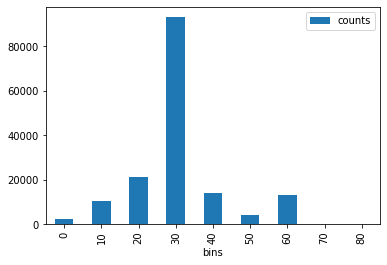

In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
hist_dur.set_index('bins'
            ).plot(kind='bar')
plt.show()

Interpretation - at that point in time, most kickstarter were 19-39 days old

In [34]:
#trying to make a histogram showing actual money earned from campaign
#the outliers threw off the bins and we tried to manually set the bin size (unsuccessful)
histogram_earn = (
    no_outliers
    .select('usd_pledged')
    .rdd
    .flatMap(lambda record: record)
    .histogram([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])

)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
for i in histogram_earn:
    print(i)
    
histogram_earn

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
[74040, 15654, 10757, 8469, 5586, 6393, 4092, 3258, 2829]
([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], [74040, 15654, 10757, 8469, 5586, 6393, 4092, 3258, 2829])

In [36]:
#display bin ranges. as mentioned above, we wanted to manually set the bin sizes
for i in range(len(histogram_earn[0])-1):
    print('[' + str(round(histogram_earn[0][i],2))
        + ',' + str(round(histogram_earn[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0,1000)
[1000,2000)
[2000,3000)
[3000,4000)
[4000,5000)
[5000,6000)
[6000,7000)
[7000,8000)
[8000,9000)

In [37]:
#Python zip function returns an iterator of tuples based on the iterable object
numberList = [1, 2, 3]
strList = ['one', 'two', 'three']
result = zip(numberList, strList)
print(sorted(result))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(1, 'one'), (2, 'two'), (3, 'three')]

In [38]:
sorted(zip(*histogram_earn))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, 74040), (1000, 15654), (2000, 10757), (3000, 8469), (4000, 5586), (5000, 6393), (6000, 4092), (7000, 3258), (8000, 2829)]

In [39]:
%%spark -o hist_MPG 
#The above Spark magic exports hist_MPG to local node running the notebook
#So that we can use the local object to draw a histogram
import pandas as pd
hist_MPG =  spark.createDataFrame(
    list(zip(*histogram_earn)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

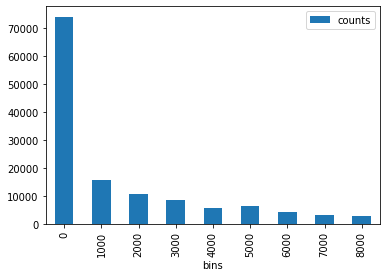

In [40]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
hist_MPG.set_index('bins'
            ).plot(kind='bar')
plt.show()

Interpretation: the outlier caused everything to be binned together, which is why were trying to hard set bin size

Scatter Plots

In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [42]:
%%spark -o scatter
#scatter plot of duration and goal
#spark magic moves dataframe to local
scatter = (
   no_outliers
    .select('blurb_length', ('usd_pledged'))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
%%local
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()
p = figure(title = 'usd_pledged x blurb_length')
p.xaxis.axis_label = 'blurb_length'
p.yaxis.axis_label = 'usd_pledged'

p.circle(  list(scatter['blurb_length'])
         , list(scatter['usd_pledged'])
         , fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...

In [44]:
%%spark -o scatter
#spark magic moves dataframe to local
scatter = (
    no_outliers
    .select('duration', 'usd_pledged')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
%%local
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()
p = figure(title = 'usd_pledged x duration')
p.xaxis.axis_label = 'duration'
p.yaxis.axis_label = 'usd_pledged'

p.circle(  list(scatter['duration'])
         , list(scatter['usd_pledged'])
         , fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...

Interpretation - the outliers are skewing the results again

Machine Learning Modeling

In [46]:
#drop categories we are not interested in for analysis
y=[ "sub_category", "currency", "launched_at", "deadline", "city", "state","end_month","start_Q","end_Q",'country']
merc_out = merc_out.drop(*y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
#convert status to boolean
from pyspark.sql import functions as Fun
df =merc_out.withColumn("Status_bool", Fun.when(Fun.col("Status") == "failed", 0).otherwise(1))
df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[id: int, name: string, main_category: string, duration: int, goal_usd: int, blurb_length: int, name_length: int, status: string, start_month: int, usd_pledged: double, Status_bool: int]

In [48]:
#convert main_category to dummies 
#removed country as dummies bc not useful for business question
import pyspark.sql.functions as f

types = df.select("main_category").distinct().rdd.flatMap(lambda x: x).collect()
types_expr = [f.when(f.col("main_category") == ty, 1).otherwise(0).alias("e_main_category_" + ty) for ty in types]
dummies_only = df.select("id", "main_category", *types_expr)
dummies_only.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------------+-------------------+--------------------------+----------------------------+--------------------------+--------------------+--------------------------+---------------------+---------------------------+---------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+-----------------------+
|      id|main_category|e_main_category_art|e_main_category_publishing|e_main_category_film & video|e_main_category_technology|e_main_category_food|e_main_category_journalism|e_main_category_dance|e_main_category_photography|e_main_category_games|e_main_category_crafts|e_main_category_music|e_main_category_comics|e_main_category_theater|e_main_category_design|e_main_category_fashion|
+--------+-------------+-------------------+--------------------------+----------------------------+--------------------------+--------------------+--------------------------+---------------------+---------------------------+-

In [49]:
#join newly made dummies with the rest of the data set
df_dummies = df.join(dummies_only, on='id')
df_dummies.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+-------------+--------+--------+------------+-----------+----------+-----------+------------+-----------+-------------+-------------------+--------------------------+----------------------------+--------------------------+--------------------+--------------------------+---------------------+---------------------------+---------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+-----------------------+
|      id|                name|main_category|duration|goal_usd|blurb_length|name_length|    status|start_month| usd_pledged|Status_bool|main_category|e_main_category_art|e_main_category_publishing|e_main_category_film & video|e_main_category_technology|e_main_category_food|e_main_category_journalism|e_main_category_dance|e_main_category_photography|e_main_category_games|e_main_category_crafts|e_main_category_music|e_main_category_comics|e_main_category_theater|e_main_category_design

In [50]:
df_dummies

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[id: int, name: string, main_category: string, duration: int, goal_usd: int, blurb_length: int, name_length: int, status: string, start_month: int, usd_pledged: double, Status_bool: int, main_category: string, e_main_category_art: int, e_main_category_publishing: int, e_main_category_film & video: int, e_main_category_technology: int, e_main_category_food: int, e_main_category_journalism: int, e_main_category_dance: int, e_main_category_photography: int, e_main_category_games: int, e_main_category_crafts: int, e_main_category_music: int, e_main_category_comics: int, e_main_category_theater: int, e_main_category_design: int, e_main_category_fashion: int]

In [51]:
#dropping any repeat and unnecessary columns 
#removed usd_pledged because it would be highly correlated with status
undumb =[ "main_category","id","name",'status','usd_pledged']
all_dummies = df_dummies.drop(*undumb)
all_dummies

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[duration: int, goal_usd: int, blurb_length: int, name_length: int, start_month: int, Status_bool: int, e_main_category_art: int, e_main_category_publishing: int, e_main_category_film & video: int, e_main_category_technology: int, e_main_category_food: int, e_main_category_journalism: int, e_main_category_dance: int, e_main_category_photography: int, e_main_category_games: int, e_main_category_crafts: int, e_main_category_music: int, e_main_category_comics: int, e_main_category_theater: int, e_main_category_design: int, e_main_category_fashion: int]

In [52]:
import pyspark.ml.evaluation as ev
import pyspark.ml.classification as cl
from pyspark.ml import Pipeline

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Chi-Square Selector

In [53]:
#exclude the label CoverType from features vector
vectorAssembler = feat.VectorAssembler(
    inputCols=all_dummies.columns[0:5]+all_dummies.columns[6:]
    , outputCol='features'
)

#select top 5 features, store in a new column named selected
selector = feat.ChiSqSelector(
    labelCol='Status_bool'
    , numTopFeatures=5
    , outputCol='selected')

pipeline_sel = Pipeline(stages=[vectorAssembler, selector])

model = (
    pipeline_sel
    .fit(all_dummies)
    .transform(all_dummies)
)

#print selected features
model.schema['selected'].metadata

#appears duration, goal_usd, blurb_length, name_length, start_month are the top 5 features

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'duration'}, {'idx': 1, 'name': 'goal_usd'}, {'idx': 2, 'name': 'blurb_length'}, {'idx': 3, 'name': 'name_length'}, {'idx': 4, 'name': 'start_month'}]}, 'num_attrs': 5}}

Correlation Matrix

In [66]:
%%spark -o corr
import pyspark.ml.stat as st

features_and_label = feat.VectorAssembler(
    inputCols=all_dummies.columns
    , outputCol='features'
)

corr = st.Correlation.corr(
    features_and_label.transform(all_dummies), 
    'features', 
    'pearson'
)

print(str(corr.collect()[0][0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseMatrix([[ 1.00000000e+00,  2.58907005e-02,  2.66844688e-02,
              -1.78058501e-02,  8.34649910e-03, -1.51837670e-01,
              -3.52253682e-02, -1.16168581e-02,  3.04332993e-03,
               7.43325702e-02,  3.28554968e-02,  1.36779693e-02,
              -1.23599435e-02, -7.89645951e-03, -4.50519975e-02,
              -2.67298048e-02,  3.32181144e-02, -2.65767796e-02,
              -1.44111197e-02, -5.40698703e-03, -2.19879550e-02],
             [ 2.58907005e-02,  1.00000000e+00, -3.55025334e-03,
              -5.72843422e-03,  2.74735551e-03, -3.24538606e-02,
              -2.45637289e-03, -9.24015577e-03,  2.45874042e-02,
               9.14446282e-03,  2.28863371e-03,  2.23705811e-03,
              -4.18694463e-03, -4.77470935e-03, -1.11955670e-03,
              -5.34359533e-03, -1.13435057e-02, -6.13926954e-03,
              -7.68885139e-04,  1.98280732e-03, -5.47994198e-03],
             [ 2.66844688e-02, -3.55025334e-03,  1.00000000e+00,
               1.372956

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
%%local
#this cell exports the correlation matrix to csv
import numpy as np
import pandas as pd
output_np = np.array(corr.iloc[0, 0]['values']).reshape(
    (corr.iloc[0, 0]['numRows'], corr.iloc[0, 0]['numCols']))
pd.DataFrame(output_np).to_csv('kick_corr.csv')
#overall not strong correlation, all less than 0.2
#small correlation, (duration vs. status), (status vs food ctegory), (film category vs. music)

In [68]:
#print the 10 selected features
num_of_features = 10
cols = dict([
    (i, e) 
    for i, e 
    in enumerate(all_dummies.columns)
])

corr_matrix = corr.collect()[0][0]
label_corr_with_idx = [
    (i[0], e) 
    for i, e 
    in np.ndenumerate(corr_matrix.toArray()[:,0])
][1:]

label_corr_with_idx_sorted = sorted(
    label_corr_with_idx
    , key=lambda el: -abs(el[1])
)

features_selected = np.array([
    cols[el[0]] 
    for el 
    in label_corr_with_idx_sorted
])[0:num_of_features]

features_selected

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['Status_bool', 'e_main_category_technology',
       'e_main_category_games', 'e_main_category_art',
       'e_main_category_music', 'e_main_category_food',
       'e_main_category_crafts', 'blurb_length', 'e_main_category_comics',
       'goal_usd'], dtype='<U28')

Logistic Regression

In [57]:
#split into train and test sets
kick_train, kick_test = (
    all_dummies
    .randomSplit([0.7, 0.3], seed=666)
)

#convert all features ti vector except for last column
vectorAssembler = feat.VectorAssembler(
    inputCols=all_dummies.columns[0:-1]

    , outputCol='features'
)

#select top 5 predictors
selector = feat.ChiSqSelector(
    labelCol='Status_bool'
    , numTopFeatures=5
    , outputCol='selected'
)

#create a multinomial regression object
#DV has 7 classes
logReg_obj = cl.LogisticRegression(
    labelCol='Status_bool'
    , featuresCol=selector.getOutputCol()
    , regParam=0.01
    , elasticNetParam=1.0
)

#create pipeline of 1)vector, 2)chisquare selector, 3)logistic regression
pipeline = Pipeline(
    stages=[
        vectorAssembler
        , selector
        , logReg_obj
    ])
#train the model
pModel = pipeline.fit(kick_train) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
results_logReg = (
    pModel
    .transform(kick_test)
   
)
a=results_logReg.select('Status_bool', 'probability', 'prediction')
#evaluate performance of the multinomial model
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='Status_bool')

(
    #F-1 score
    evaluator.evaluate(a)
    #weighted precision
    , evaluator.evaluate(
       a
        , {evaluator.metricName: 'weightedPrecision'}
    ) 
    #accuracy
    , evaluator.evaluate(
        a
        , {evaluator.metricName: 'accuracy'}
    )
)
#output changed again

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.572453761922425, 0.6047435754119233, 0.6050866960282506)

In [59]:
pModel.stages[-1].coefficients

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([-0.0227, -0.0, -0.0046, 0.0922, 0.0])

In [60]:
results_logReg.schema['selected'].metadata

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'duration'}, {'idx': 1, 'name': 'goal_usd'}, {'idx': 2, 'name': 'blurb_length'}, {'idx': 3, 'name': 'name_length'}, {'idx': 4, 'name': 'start_month'}]}, 'num_attrs': 5}}

In [61]:
results_logReg.head(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(duration=7, goal_usd=200, blurb_length=22, name_length=3, start_month=3, Status_bool=1, e_main_category_art=0, e_main_category_publishing=0, e_main_category_film & video=1, e_main_category_technology=0, e_main_category_food=0, e_main_category_journalism=0, e_main_category_dance=0, e_main_category_photography=0, e_main_category_games=0, e_main_category_crafts=0, e_main_category_music=0, e_main_category_comics=0, e_main_category_theater=0, e_main_category_design=0, e_main_category_fashion=0, features=SparseVector(20, {0: 7.0, 1: 200.0, 2: 22.0, 3: 3.0, 4: 3.0, 5: 1.0, 8: 1.0}), selected=SparseVector(5, {0: 7.0, 1: 200.0, 2: 22.0, 3: 3.0, 4: 3.0}), rawPrediction=DenseVector([-0.5658, 0.5658]), probability=DenseVector([0.3622, 0.6378]), prediction=1.0), Row(duration=10, goal_usd=5000, blurb_length=15, name_length=5, start_month=5, Status_bool=0, e_main_category_art=1, e_main_category_publishing=0, e_main_category_film & video=0, e_main_category_technology=0, e_main_category_food=0, e_

Random Forest Classifer

In [62]:
rf_obj = cl.RandomForestClassifier(
    labelCol='Status_bool'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)

pipeline = Pipeline(
    stages=[vectorAssembler, selector, rf_obj]
)

pModel2 = pipeline.fit(kick_train)

results_rf = (
    pModel2
    .transform(kick_test)
)
a=results_rf.select('Status_bool', 'probability', 'prediction')
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='Status_bool')

(
    evaluator.evaluate(a)
    , evaluator.evaluate(
        a
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        a
        , {evaluator.metricName: 'accuracy'}
    )
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.6299876857983263, 0.6550679611864505, 0.6498631115343412)

In [63]:
#print selected features
results_rf.schema['selected'].metadata

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'duration'}, {'idx': 1, 'name': 'goal_usd'}, {'idx': 2, 'name': 'blurb_length'}, {'idx': 3, 'name': 'name_length'}, {'idx': 4, 'name': 'start_month'}]}, 'num_attrs': 5}}

In [64]:
a.head(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(Status_bool=1, probability=DenseVector([0.3525, 0.6475]), prediction=1.0), Row(Status_bool=0, probability=DenseVector([0.3495, 0.6505]), prediction=1.0), Row(Status_bool=1, probability=DenseVector([0.3495, 0.6505]), prediction=1.0), Row(Status_bool=1, probability=DenseVector([0.3127, 0.6873]), prediction=1.0), Row(Status_bool=0, probability=DenseVector([0.3127, 0.6873]), prediction=1.0)]

In [65]:
a.show(5)
#unexpecting probability

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+----------+
|Status_bool|         probability|prediction|
+-----------+--------------------+----------+
|          1|[0.35249658268508...|       1.0|
|          0|[0.34947561322617...|       1.0|
|          1|[0.34947561322617...|       1.0|
|          1|[0.31274830087956...|       1.0|
|          0|[0.31274830087956...|       1.0|
+-----------+--------------------+----------+
only showing top 5 rows